# PRUNING SPARCITY AND ACCURACY

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.nn.utils.prune as prune
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
"""
    Intialising list of k values.  
"""
k_list = [val/100 for val in [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]]

In [3]:
"""
    If GPU is available then run on GPU else run on CPU
"""
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)  

In [4]:
"""
    . torchvision.datasets.MNIST downloads PIL images 
    . Hence we need to define transform object to convert downloaded MNIST PIL images to Tensors
    . Batch size of 32 was used. 
    . Intiliasing only the test data loader because we want to test the Accuracy scores for each Sparsity in k_list
"""
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Creating Data Loader object for creating the Test set by using the field train=False 
test_data = torchvision.datasets.MNIST("./",train=False,download=True,transform=transform)
test_data_loaded = torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True)

In [5]:
"""
Initialising the Model class exactly same as mtrained model

input (inp) ==> 28*28 neurons
layer1      ==> 1000 neurons
layer2      ==> 1000 neurons
layer3      ==> 500 neurons
layer4      ==> 200 neurons
output(out) ==> 10 neurons  Since number of classes are 10

* Softmax layer is not being used as the final layer becuase Crossentropy loss
  is being used which takes the input as logits and calculates softmax before computing loss. 
"""

class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.inp = nn.Linear(28*28,1000)
        self.layer1 = nn.Linear(1000,1000)
        self.layer2 = nn.Linear(1000,1000)
        self.layer3 = nn.Linear(1000,500)
        self.layer4 = nn.Linear(500,200)
        self.out = nn.Linear(200,10)
    
    def forward(self,x):
        x = torch.flatten(x,1)
        x = self.inp(x)
        x = F.relu(x)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = F.relu(x)
        x = self.out(x)
        #x = F.softmax(x,dim = 1)
        return x

In [6]:
"""
    This function returns the Sparsity and Accuracy of the model with k % Pruning 
"""
def get_sparsity_accuracy(nmodel,test_data_loaded,device):
    
    """
       Calculating sum of all weights = 0 in the model.
    """
    global_sparsity = float(torch.sum(nmodel.inp.weight == 0))        
    global_sparsity += float(torch.sum(nmodel.layer1.weight == 0))
    global_sparsity += float(torch.sum(nmodel.layer2.weight == 0))
    global_sparsity += float(torch.sum(nmodel.layer3.weight == 0))
    global_sparsity += float(torch.sum(nmodel.layer4.weight == 0))
    
    """
       Calculating total number of weights in the model.
    """
    total_no_of_weights = float(  nmodel.inp.weight.nelement()
                                + nmodel.layer1.weight.nelement()
                                + nmodel.layer2.weight.nelement()
                                + nmodel.layer3.weight.nelement()
                                + nmodel.layer4.weight.nelement())
    """
       Calculating Sparsity =  (sum of all weights equal to 0) / (total number of weights in the model)
    """
    
    percent_sparsity = 100.0 * (global_sparsity/total_no_of_weights)
    print("Global sparsity: {:.2f}%".format(percent_sparsity))
    
    """
       Calculating the Accuracy of the pruned model on the Test set
    """
    
    num_correct = 0
    time_ = 0
    for i,images in enumerate(test_data_loaded):
        batch_images,batch_labels = images                           # iterate over the batches of training data
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        with torch.no_grad():
            start = time.time()
            outputs = nmodel(batch_images)                           # computing forward pass 
            end = time.time()
            num_correct += (batch_labels == outputs.max(dim=1)[1])   # Calculating total number of correct outputs 
            time_ += end - start
    accuracy = 100*num_correct.sum()/len(test_data_loaded.dataset)   # Accuracy = numbr of correct outputs / total test samples
    print("Accuracy: {:.2f}%".format(accuracy))
    return [percent_sparsity,round(float(accuracy),2),float(time_)/float(i)]

## WEIGHT PRUNING

In [7]:
"""
1)  Perform Weight Pruning to prune away k% neurons/units for k in  [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
2)  Choose all layers other than the output layer and rank the weights using the absolute values
    by using the l1_unstructured function. 
3)  Calculate Sparsity in layers and the Accuracy of the Pruned model on the Test set.


Reference -->  https://pytorch.org/tutorials/intermediate/pruning_tutorial.html
"""
data = []
for k in k_list:
    nmodel = Model()
    nmodel.to(device)
    #nmodel = torch.load("mnists.pth")
    nmodel.load_state_dict(torch.load("mnist.pth"))                     # Loading weights of pre-trained MNIST pytorch model
    nmodel.eval()

    for name, module in nmodel.named_modules():
        if name not in ["","out"]:
            prune.l1_unstructured(module, name='weight', amount=k)
    
    data.append(get_sparsity_accuracy(nmodel,test_data_loaded,device))

Global sparsity: 0.00%
Accuracy: 97.98%
Global sparsity: 25.00%
Accuracy: 98.01%
Global sparsity: 50.00%
Accuracy: 97.96%
Global sparsity: 60.00%
Accuracy: 97.92%
Global sparsity: 70.00%
Accuracy: 97.56%
Global sparsity: 80.00%
Accuracy: 96.76%
Global sparsity: 90.00%
Accuracy: 77.95%
Global sparsity: 95.00%
Accuracy: 34.19%
Global sparsity: 97.00%
Accuracy: 9.96%
Global sparsity: 99.00%
Accuracy: 9.74%


In [8]:
df = pd.DataFrame(data,columns=['% Sparsity', '% Accuracy',"Execution Time"])
print(df)

   % Sparsity  % Accuracy  Execution Time
0         0.0       97.98        0.002655
1        25.0       98.01        0.000325
2        50.0       97.96        0.000986
3        60.0       97.92        0.000434
4        70.0       97.56        0.000883
5        80.0       96.76        0.000595
6        90.0       77.95        0.000885
7        95.0       34.19        0.000851
8        97.0        9.96        0.000198
9        99.0        9.74        0.000682


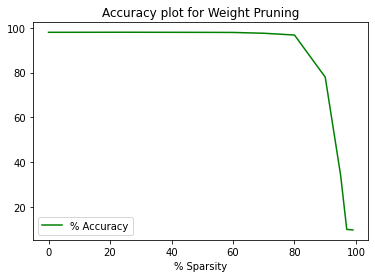

In [9]:
df.plot(kind = 'line',
        x = '% Sparsity',
        y = '% Accuracy',
        color = 'green')

plt.title('Accuracy plot for Weight Pruning')

plt.show()

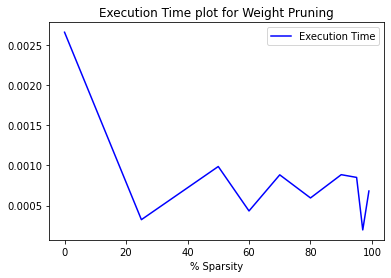

In [10]:
df.plot(kind = 'line', x = '% Sparsity', y = "Execution Time", color = 'blue')
plt.title("Execution Time plot for Weight Pruning")
plt.show()

## UNIT PRUINING

In [11]:
def get_pruned_layer_weights(weight_array):
    """
    1) Function to create a binary mask for 
        performing Unit Pruning
    """
    l2norm = []
    for neuron,neuron_weights in enumerate(weight_array):
        l2norm.append(np.linalg.norm(neuron_weights))
    ind = np.array(l2norm).argsort()
    percent_to_prune = k
    ind_weights_to_prune = ind[:int(k*float(len(ind)))]
    new_weight = np.ones_like(weight_array)
    for n in ind_weights_to_prune:
        new_weight[n] = np.zeros_like(weight_array[n])
    return new_weight

class Unit_pruning(prune.BasePruningMethod):
    """
    1) Prune or Detach a unit/neuron in a layer by making all its weights = 0.
    2) Calculate L2 norm of each neuron's weights in a layer, prune away 
       units/neurons with the lowest k% L2 norms.   
    """
    PRUNING_TYPE = 'unstructured'

    def compute_mask(self, t, default_mask):
        weight_array = t.detach().cpu().numpy()
        mask = get_pruned_layer_weights(weight_array)
        mask = torch.from_numpy(mask)
        mask = mask.to(device)
        return mask

def unit_prune_layer(module, name):
    """
    1)  Function to call the Unit pruning which will add a
        mask buffer to the module/layer
    """
    Unit_pruning.apply(module, name)
    return module

In [12]:
"""
1)  Perform Unit Pruning to prune away k% neurons/units for k in  [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
2)  Choose all layers other than the output layer and apply unit_prune_layer function to add the 
    binary mask buffer to the layer
3)  Calculate Sparsity in layers and the Accuracy of the Pruned model on the Test set.

Reference -->  https://pytorch.org/tutorials/intermediate/pruning_tutorial.html 
"""
data = []
for k in k_list:
    unit_model = Model()
    unit_model.to(device)
    unit_model.load_state_dict(torch.load("mnist.pth"))
    unit_model.eval()
    for name,layer in unit_model.named_modules():
        
        if name not in ["","out"]:
            unit_prune_layer(layer, name='weight')
    
    data.append(get_sparsity_accuracy(unit_model,test_data_loaded,device))

Global sparsity: 0.00%
Accuracy: 97.98%
Global sparsity: 25.00%
Accuracy: 98.02%
Global sparsity: 50.00%
Accuracy: 97.57%
Global sparsity: 60.00%
Accuracy: 87.50%
Global sparsity: 70.00%
Accuracy: 85.94%
Global sparsity: 80.00%
Accuracy: 78.97%
Global sparsity: 90.00%
Accuracy: 36.33%
Global sparsity: 95.00%
Accuracy: 9.74%
Global sparsity: 97.00%
Accuracy: 9.74%
Global sparsity: 99.00%
Accuracy: 9.74%


In [13]:
df1 = pd.DataFrame(data,columns=['% Sparsity' , '% Accuracy' , "Execution Time"])
print(df1)

   % Sparsity  % Accuracy  Execution Time
0         0.0       97.98        0.000853
1        25.0       98.02        0.000435
2        50.0       97.57        0.000814
3        60.0       87.50        0.000202
4        70.0       85.94        0.000503
5        80.0       78.97        0.000316
6        90.0       36.33        0.000600
7        95.0        9.74        0.000614
8        97.0        9.74        0.000692
9        99.0        9.74        0.000548


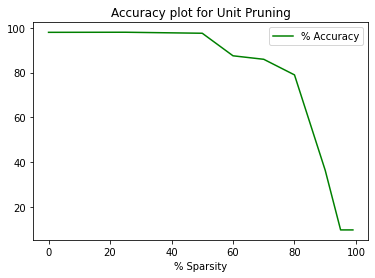

In [14]:
df1.plot(kind = 'line', x = '% Sparsity', y = '% Accuracy', color = 'green')
plt.title('Accuracy plot for Unit Pruning')
plt.show()

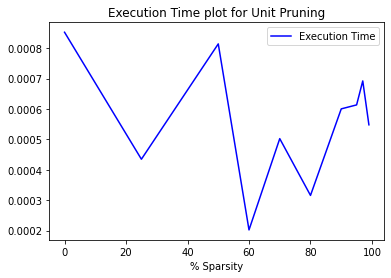

In [15]:
df1.plot(kind = 'line', x = '% Sparsity', y = "Execution Time", color = 'blue')
plt.title('Execution Time plot for Unit Pruning')
plt.show()

# ANALYSIS OF RESULTS

- **Pruning** is a process to remove the insignificant weights or units in the network without affecting the overall accuracy of the model.   
- Another benefit of pruning the model is that a pruned model is light and ecutes faster than the orginal model.

## What interesting insights did you find? 

- From the plots for %Sparsity vs %Accuracy we could see that the Accuracy of the pruned model almost remains the same to that   of the original till we prune about 80% of the weights in the Weight Pruining method and 50% in the Unit Pruning method.
- Another interesting find was that the accuracy of the model slightly increased when the %Sparity = 25 which says that pruning   the model nullified the weights that lead to wrong classification of a few samples.
- If we consider % Sparsity = 25% we can also see that the exceution time for the model decreased by 87% by using weight         pruning and 50% by using Unit Pruning.  


## Do the curves differ?

- Yes, the curves differ.  
- The Accuracy curve remains almost constant till about 80% Sparsity using the Weight Pruning whereas it remains constant only till 50% Sparsity in Unit Pruning. 

## Why do you think that is/isn’t? 

- In Weight Pruining we consider all the weights in a layer rank them according to their absolute values and pruning the weights with the least k% values (l1 norm) whereas in Unit pruning we take L2 scores of each neuron and disconnect the entire neuron.
- This leads to different distribution of weights being pruned in Weight and Unit Pruning.
- By Unit Pruning a model one might delete a certain neuron that might have weights significant for model accuracy which would not have been deleted by Weight Pruning.
- This leads to difference in curves

## Do you have any hypotheses as to why we are able to delete so much of the network without hurting performance (this is an open research question)?

- A trained model will have some weights that are very significant (with large absolute values) for neuron activation on the other hand there might be weights that are very insignificant.(with absolute values very close to 0)


- Removing these insignificant weights will cause negligible change in neuron activations in the next layer and thus if pruned till a certain amount will not affect the overall accuracy of the model much.

- While pruning we rank the weights according to l1 scores in WP and according to L2 in UP and we prune the weights/neurons with the least k% scores. By doing this we are performing a similar action to the example shown below:

                                          neuron activation  = f(W * X_T + B)                     
  
                   where f(x) is relu, W is weight matrix, X_T  is transpose of input from previous layer
                                                                
  - consider a weight matrix [w1 ,w2 ,w3 ,w4 , w5] among which values of w3 and w4 are very small
  
                                        neuron activation = f (w1x1 + w2x2 + w3x3 + w4x4 + w5x5 + B)
  
  - if we replace w3 and w4 equal to 0 we can see that the neuron activation will not be affected by a large amount.




- This is a reason why we are able to prune so much of the network without hurting the Accuracy scores. 
  
  
  

## Bonus

### See if you can find a way to use your new-found sparsity to speed up the execution of your neural net! This can be tricky but is a worthwhile engineering lesson in the optimization of your models.

- For Understanding the change in execution time after Pruining the models, I have recorded the time it takes for the pruned model to run the inference on the test set. The time we calculated as the average time the model took to run each test batch.
- If consider k = 25% we can see that there is a significant drop in the excution times for the pruned models, 87% drop in Weight Pruning method and 49% drop in Unit Pruining method. 